 # Neural Network using Numpy

 In this notebook, I am going to build a neural  
 network from scratch using Numpy.  
 The neural network will be trained on an open source  
 Bike Sharing Dataset to predict bike sharing patterns.

# Set up the Environment
 Import the necessary libraries and configure pandas.

In [1]:
# Matplotlib configs 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Enable autoreload 
%load_ext autoreload
%autoreload 2

# Import the bare minimum libraries 
import numpy as np
import pandas as pd
import pandas_profiling # This is a personal fav! 
import matplotlib.pyplot as plt

In [2]:
# Configure Pandas Display Options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Load the Data and perform EDA 
Time to load the data for our Neural Network.  
We will also be performing exploratory data  
analysis on the dataset to get the lay of the  
land. 

In [3]:
data_path = '../Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)

In [4]:
# View the data 
display(rides.shape)
rides.sample(5)

(17379, 17)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
874,875,2011-02-08,1,0,2,21,0,2,1,1,0.14,0.1061,0.33,0.4627,8,46,54
13908,13909,2012-08-07,3,1,8,17,0,2,1,2,0.78,0.7424,0.62,0.1343,125,743,868
6734,6735,2011-10-13,4,0,10,4,0,4,1,2,0.54,0.5152,1.00,0.1045,2,5,7
13835,13836,2012-08-04,3,1,8,16,0,6,0,1,0.90,0.8182,0.39,0.2985,197,253,450
5457,5458,2011-08-20,3,0,8,7,0,6,0,1,0.62,0.5758,0.83,0.0000,8,36,44


Let's get some more clarity on this dataset.  
`cnt` is the total number of riders on any given day.  
We will be trying to predict `cnt` through our Neural Net. 

In [5]:
display(rides)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


Looking at the values above, this dataset contains the  
hourly ridership of the bike sharing company over a  
period of 2 years. There are roughly 24 entries (for  
24 hours) for every day.

<br/>Let's make a plot of the ridership in the first 15 days. 

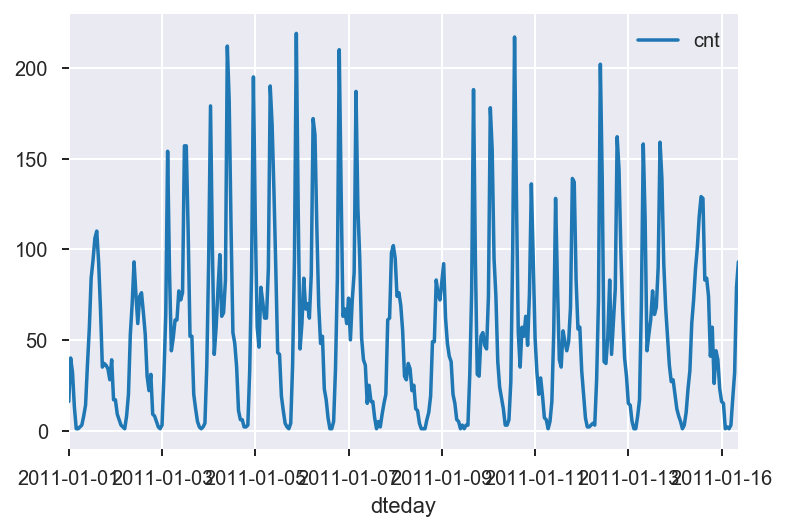

In [6]:
rides[:24*15].plot(x='dteday', y='cnt')

The plot above indicates that the data is highly  
periodic in nature. 

<br/>Let's profile the whole dataset using Pandas Profiling. 

In [7]:
# COnfigure the report style 
rides.profile_report(style={'full_width':True})
rides.profile_report()

## Pre-process the Data 
From the above profiling report, we can see that there  
are a few categorical variables that need to be one-hot  
encoded. A few numerical variables will also be better  
served by converting them into one-hot encoded ones. 

In [8]:
# Create one-hot encoded columns 
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

# Drop the one-hot enccoded fields and some more     
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Scaling Target Variables 
Training the network is easier when our variables are _standardized_.  
That is, they have a zero mean and a standard deviation of 1.  
This helps in the training because a large variance in the variable  
values could result in Gradient Descent not converging.

<br/> We will save the scaling factors so that we can use them later on  
while making the predictions. 

In [9]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [10]:
# Verify 
print(data['casual'].mean())
print(data['casual'].std())
print(data['cnt'].mean())
print(data['cnt'].std())

3.270810683054722e-17
1.0
-9.321810446705958e-17
1.0


## Training, Testing and Validation Sets 
Now that we have pre-processed our data, split it into Training,  
Testing and Validation sets.  
We will use the data from the last 21 days as our test set. 

In [11]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [12]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [15]:
print(data.shape)
print(test_data.shape)
print(train_features.shape)
print(val_features.shape)

(16875, 59)
(504, 59)
(15435, 56)
(1440, 56)
